# Começamos importando as bibliotecas necessárias

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
import warnings
warnings.filterwarnings("ignore")

# Agora obtemos a planilha e limpamos os dados

Aqui vamos usar uma planilha com dados utilizados por empresas de seguros de saúde para avaliar o custo de cada beneficiário a partir de informações como idade, gênero, IMC, se é fumante, etc.

In [10]:
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv', header=None)
df

,0,1,2,3,4,5,6
0,19,1,27.900,0,1,3,16884.92400
1,18,2,33.770,1,0,4,1725.55230
2,28,2,33.000,3,0,4,4449.46200
3,33,2,22.705,0,0,1,21984.47061
4,32,2,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
2767,47,1,45.320,1,0,4,8569.86180
2768,21,1,34.600,0,0,3,2020.17700
2769,19,2,26.030,1,1,1,16450.89470
2770,23,2,18.715,0,0,1,21595.38229


Adicionamos os headers de acordo com informações da fonte do banco de dados

In [11]:
Head = ['idade','genero', 'IMC', 'no_filhos', 'fumante', 'regiao', 'custos']

df.columns = Head

Aqui substituimos os "?" por NaN para facilitar a manipulação de dados ausentes com o pandas

In [12]:
df.replace("?", np.nan, inplace=True) 

Vamos agora verificar quais colunas apresentam dados ausentes e quantos são por coluna

In [13]:
df.isna().sum()

idade        4
genero       0
IMC          0
no_filhos    0
fumante      7
regiao       0
custos       0
dtype: int64

Com essa informação conseguimos escolher o melhor método de substituição de dados ausentes baseado nos valores de cada coluna. Para idade vamos subistituir pela média, e para os fumantes vamos substituir pela moda

In [14]:
avg_idade= df['idade'].astype(float).mean(axis=0)

df['idade'].replace(np.nan, avg_idade, inplace=True)



In [15]:
mode_fumante= df['fumante'].mode()

df['fumante'].replace(np.nan, mode_fumante[0], inplace=True)



In [16]:
df.isna().sum()

idade        0
genero       0
IMC          0
no_filhos    0
fumante      0
regiao       0
custos       0
dtype: int64

Em seguida vamos transformar o tipo de dado dessas colunas em int, e mudar a quantidade de decimais da coluna 'custos' para somente dois. Isso irá facilitar as análises

In [17]:
df[['idade','fumante']] = df[['idade','fumante']].astype('int') 

In [18]:
df['custos'] = df['custos'].round(decimals=2) 

# Análise exploratória

Vamos começar com uma visualização de algumas variáveis do banco de dados

(0.0, 66902.85800000001)

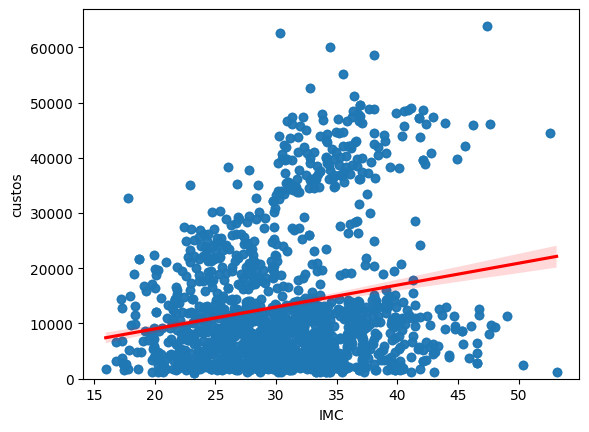

In [19]:
sns.regplot(x="IMC", y="custos", data=df, line_kws={"color": "red"})
plt.ylim(0,)

<Axes: xlabel='fumante', ylabel='custos'>

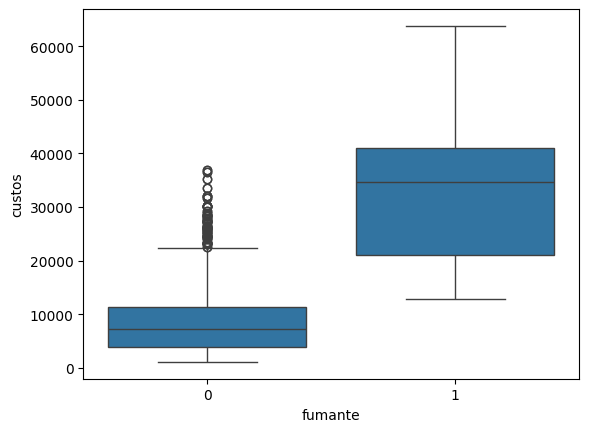

In [20]:
sns.boxplot(x='fumante', y='custos', data=df)

E então fazemos uma planilha de correlação para avaliar como essas variáveis interagem. Vemos que os custos tem relação mais forte com o fato de ser fumante, seguido da idade e do IMC

In [21]:
df_corr = df.corr() 
print(df_corr)

              idade    genero       IMC  no_filhos   fumante    regiao  \
idade      1.000000 -0.026046  0.113048   0.037574 -0.023286 -0.007167   
genero    -0.026046  1.000000  0.042924   0.016020  0.082326  0.022213   
IMC        0.113048  0.042924  1.000000  -0.001492  0.011489  0.271119   
no_filhos  0.037574  0.016020 -0.001492   1.000000  0.006362 -0.025717   
fumante   -0.023286  0.082326  0.011489   0.006362  1.000000  0.054077   
regiao    -0.007167  0.022213  0.271119  -0.025717  0.054077  1.000000   
custos     0.298624  0.062837  0.199846   0.066442  0.788783  0.054058   

             custos  
idade      0.298624  
genero     0.062837  
IMC        0.199846  
no_filhos  0.066442  
fumante    0.788783  
regiao     0.054058  
custos     1.000000  


# Modelos de regressão

Agora vamos desenvolver modelos de regressão utilizando o banco de dados

Fazemos primeiro uma regressão linear somente entre duas variáveis que tiveram maior correlação e verificamos o R quadrado

In [22]:
x = df[['fumante']]
y = df[['custos']]

lm = LinearRegression()
lm.fit(x, y)
print('O valor de R^2 é de', lm.score(x, y))

O valor de R^2 é de 0.6221791733924185


Em seguida, fazemos uma regressão entre todas as váriaveis e o custos, e obtemos um R quadrado mais próximo de 1

In [23]:
z = df[['idade','genero', 'IMC', 'no_filhos', 'fumante', 'regiao']]

lm.fit(z,y)
ylm = lm.predict(z)

print('O valor de R^2 é de', r2_score(y,ylm))

O valor de R^2 é de 0.7504083820289634


Agora vamos criar um pipeline para ver se conseguimos um R quadrado melhor. No pipeline vamos fazer uma transformação polinomial, normalizar os valores e fazer uma regressão linear

In [24]:
Input = [ ('polynomial', PolynomialFeatures()),('scale', StandardScaler()), ('Model', LinearRegression())]

pipe = Pipeline(Input)

pipe.fit(z,y)
ypipe = pipe.predict(z)
print('O valor de R^2 é de', r2_score(y,ypipe))

O valor de R^2 é de 0.8452576213500093


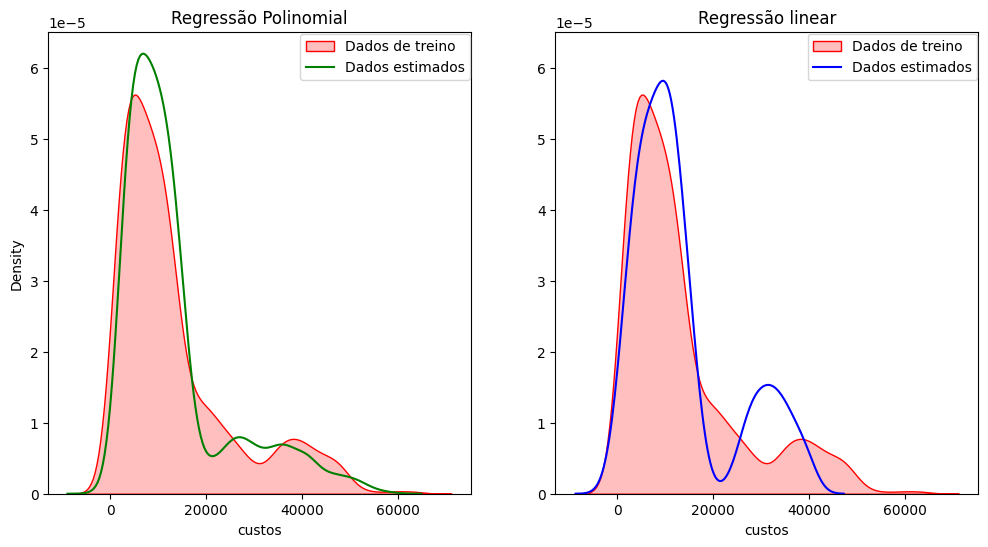

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, )


sns.kdeplot(y.squeeze(), color='red', fill=True, ax=ax[0], label = 'Dados de treino')
sns.kdeplot(ypipe.squeeze(), color='green', ax=ax[0], label = 'Dados estimados')
plt.xticks([0, 20000, 40000, 60000])

ax[1]
sns.kdeplot(y.squeeze(), color='red', fill=True, ax=ax[1], label = 'Dados de treino')
sns.kdeplot(ylm.squeeze(), color='blue', ax=ax[1], label = 'Dados estimados')


ax[0].legend(bbox_to_anchor=(1.015, 1.01), loc='upper right')
ax[0].set_title('Regressão Polinomial')
ax[1].legend(bbox_to_anchor=(0.58, 1.01), loc='upper left')
ax[1].set_title('Regressão linear')
ax[1].yaxis.set_tick_params(which='both', labelbottom=True)


plt.show()
plt.close()

Vamos tentar refinar o modelo separando os dados entre dados de treinamento e dados de teste (20% do total)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=1)

E agora vamos fazer uma regressão de crista com alfa de 0,1

In [27]:
RidgeModel=Ridge(alpha=0.1)
RidgeModel.fit(x_train, y_train)
yridge = RidgeModel.predict(x_test)
print('O valor de R^2 é de', r2_score(y_test,yridge))

O valor de R^2 é de 0.6760807731582404


Vamos fazer uma transformação polinomial para entender se nosso modelo se encaixa melhor numa regressão não linear

In [28]:
pr = PolynomialFeatures(degree=2) #pr = polinomial regression
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)

RidgeModel.fit(x_train_pr, y_train)
yridge_pr = RidgeModel.predict(x_test_pr)
print('O valor de R^2 é de', r2_score(y_test,yridge_pr))

O valor de R^2 é de 0.7835631107608146


Por fim, fazemos um plot para comparar os valores estimados com regressao linear e polinomial em relação aos valores reais utilizados no treino

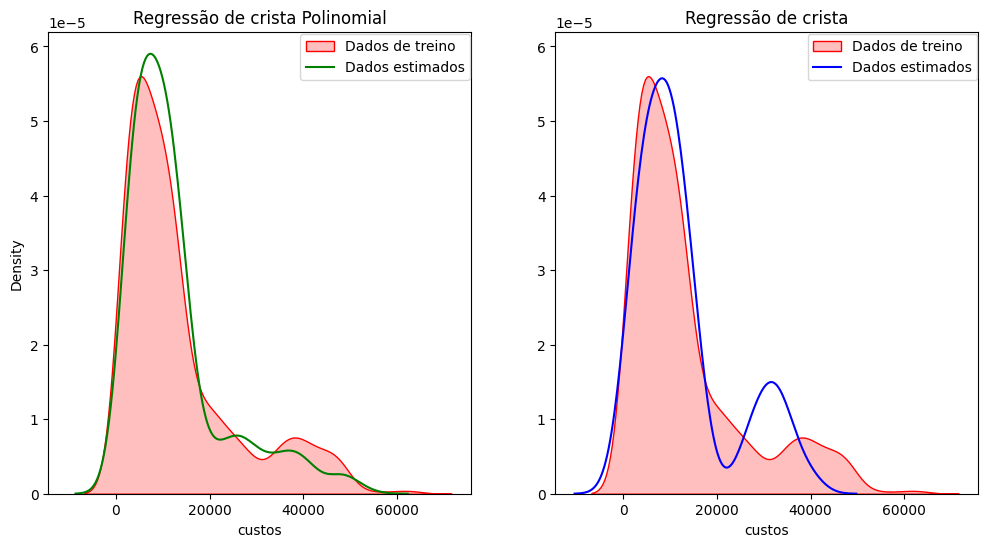

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)


sns.kdeplot(y_train.squeeze(), color='red', fill=True, ax=ax[0], label = 'Dados de treino')
sns.kdeplot(yridge_pr.squeeze(), color='green', ax=ax[0], label = 'Dados estimados')

ax[1]
sns.kdeplot(y_train.squeeze(), color='red', fill=True, ax=ax[1], label = 'Dados de treino')
sns.kdeplot(yridge.squeeze(), color='blue', ax=ax[1], label = 'Dados estimados')


ax[0].legend(bbox_to_anchor=(1.015, 1.01), loc='upper right')
ax[0].set_title('Regressão de crista Polinomial')
ax[1].legend(bbox_to_anchor=(0.58, 1.01), loc='upper left')
ax[1].set_title('Regressão de crista')
ax[1].yaxis.set_tick_params(which='both', labelbottom=True)

plt.show()
plt.close()

